# Version 1 for Infant 2 processing
1. Read the data
1. Perform interquartile range smoothing for outlier
1. Normalize the data to (-1, 1)
1. Calculate the Heart rate (BPM) and respiration rate (BPM)
1. Correlation test
1. Linear Regression


In [1]:
# Import of libraries/modules
### -------------------------------------------
import wfdb
from wfdb import processing
### ------------------------------------------- 
import scipy
from scipy.signal import butter, lfilter, filtfilt
### -------------------------------------------
import matplotlib.pyplot as plt
### -------------------------------------------
import numpy as np
### -------------------------------------------
import pandas as pd
### -------------------------------------------
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
### -------------------------------------------
import functools
### -------------------------------------------
import seaborn as sns
### -------------------------------------------
scaler = MinMaxScaler(feature_range=(-1,1))
data_dir = "../data"
infantNum = 2

In [2]:
# Some Custom Function
def startTime_num(time, fs):
    n = time * fs
    return n


def iqr_remove_outlier(x, lower, upper):
    if (x < lower):
        return lower
    elif (x > upper): 
        return upper
    else:
        return x


def correlationTest(signal_1, signal_2, plot=True):
    # Inspect by scatter plot
    if plot: 
        plt.scatter(signal_1, signal_2)
    # Covariance
    covariance = np.cov(signal_1, signal_2)
    print(covariance)
    # calculate Pearson's correlation - 0 is no correlation -1 or 1 is highly correlated
    corr, _ = scipy.stats.pearsonr(signal_1, signal_2)
    print('Pearsons correlation: %.3f' % corr)
    # calculate spearman's correlation - 0 is no correlation -1 or 1 is highly correlated
    corr, _ = scipy.stats.spearmanr(signal_1, signal_2)
    print('Spearmans correlation: %.3f' % corr)


def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a


def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def peaks_rr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Repiration rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('RESP (NU)', color='#3979f0')
    ax_right.set_ylabel('Repiration rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()


def apply_low_pass_filter(original_series, downsample_multiplier, N=5, Wn=0.1, fs=1):
    b, a = butter(N=N, Wn=Wn, btype='lowpass', fs=fs)

    # Apply the low-pass filter to the signal
    filtered_series = filtfilt(b, a, original_series)

    # Downsample the filtered signal by a factor of 10
    downsampled_series = filtered_series[::downsample_multiplier]
    
    return downsampled_series

In [3]:
# Read all the data
signal_ecg_0 = wfdb.rdsamp(f"{data_dir}/infant{infantNum}_ecg")
record_ecg_0 = wfdb.rdrecord(f"{data_dir}/infant{infantNum}_ecg")
dataframe_ecg_0 = record_ecg_0.to_dataframe()
annotation_ecg_0 = wfdb.rdann(f"{data_dir}/infant{infantNum}_ecg", 'qrsc',shift_samps=True)
signal_resp_0 = wfdb.rdsamp(f"{data_dir}/infant{infantNum}_resp")
record_resp_0 = wfdb.rdrecord(f"{data_dir}/infant{infantNum}_resp")
annotation_resp_0 = wfdb.rdann(f"{data_dir}/infant{infantNum}_resp", 'resp',shift_samps=True)
dataframe_resp_0 = record_resp_0.to_dataframe()

In [4]:
# Start and end time defined
start_time_secs = 48000
end_time_secs = 48600

ECG_startNum = startTime_num(start_time_secs, record_ecg_0.fs)
ECG_endNum = startTime_num(end_time_secs, record_ecg_0.fs)

RESP_startNum = startTime_num(start_time_secs, record_resp_0.fs)
RESP_endNum = startTime_num(end_time_secs, record_resp_0.fs)

### Read data into smaller bin

In [5]:
# ECG data bin - make the data handling more convenient by reading a smaller portion of data
duration_ECG = 30000
kth_ECG = 0
# startNum_ECG = duration_ECG*kth_ECG
startNum_ECG = ECG_startNum
# endNum_ECG = duration_ECG*(kth_ECG+1)
endNum_ECG = ECG_endNum
signals_ECG = wfdb.rdsamp(f"{data_dir}/infant{infantNum}_ecg", sampfrom=startNum_ECG, sampto=endNum_ECG)
record_ECG = wfdb.rdrecord(f"{data_dir}/infant{infantNum}_ecg", sampfrom=startNum_ECG, sampto=endNum_ECG)
dataframe_ECG = record_ECG.to_dataframe()
annotation_ECG = wfdb.rdann(f"{data_dir}/infant{infantNum}_ecg", 'qrsc', sampfrom=startNum_ECG, sampto=endNum_ECG, shift_samps=True)
startTime_seconds_ECG = startNum_ECG/record_ECG.fs
endTime_seconds_ECG = endNum_ECG/record_ECG.fs
startTime_minutes_ECG = (startTime_seconds_ECG)/60
endTime_minutes_ECG = (endTime_seconds_ECG)/60
startTime_hours_ECG = startTime_minutes_ECG/60
endTime_hours_ECG = endTime_minutes_ECG/60

In [6]:
# Generate Timestamp array
start = startTime_seconds_ECG
stop = endTime_seconds_ECG
step = 1/record_ECG.fs
time_array_seconds_ECG = np.arange(start=start, stop=stop, step=step)
time_array_minutes_ECG = time_array_seconds_ECG/60

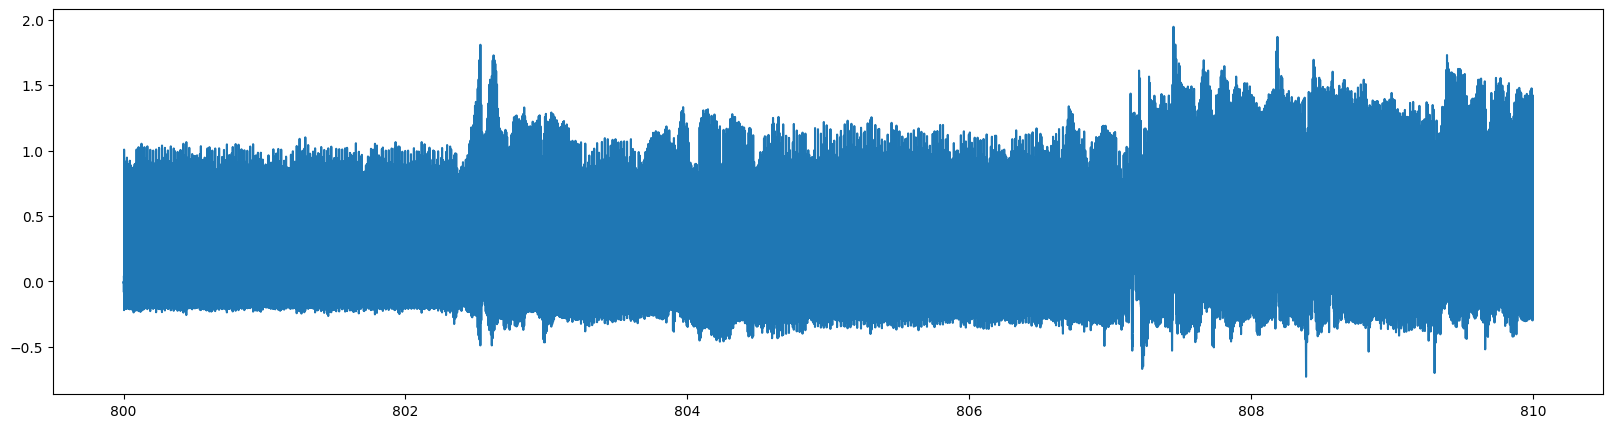

In [7]:
# Plot the ECG DATA
slice = 1
bin = int(signals_ECG[0].shape[0]/slice)
plt.figure(num=101, figsize=(20,5))
plt.plot(time_array_minutes_ECG[:bin], signals_ECG[0][:bin], label='ECG Data')

In [8]:
# RESP data bin - make the data handling more convenient by reading a smaller portion of data
duration_RESP = 60000
kth_RESP = 400
# startNum_RESP = duration_RESP*kth_RESP
startNum_RESP = RESP_startNum
# endNum_RESP = duration_RESP*(kth_RESP+1)
endNum_RESP = RESP_endNum
signals_RESP = wfdb.rdsamp(f"{data_dir}/infant1_resp", sampfrom=startNum_RESP, sampto=endNum_RESP)
record_RESP = wfdb.rdrecord(f"{data_dir}/infant1_resp", sampfrom=startNum_RESP, sampto=endNum_RESP)
dataframe_RESP = record_RESP.to_dataframe()
annotation_RESP = wfdb.rdann(f"{data_dir}/infant1_resp", 'resp', sampfrom=startNum_RESP, sampto=endNum_RESP, shift_samps=True)
startTime_seconds_RESP = startNum_RESP/record_RESP.fs
endTime_seconds_RESP = endNum_RESP/record_RESP.fs
startTime_minutes_RESP = (startTime_seconds_RESP)/60
endTime_minutes_RESP = (endTime_seconds_RESP)/60
startTime_hours_RESP = startTime_minutes_RESP/60
endTime_hours_RESP = endTime_minutes_RESP/60

In [9]:
# Generate Timestamp array
start = startTime_seconds_RESP
stop = endTime_seconds_RESP
step = 1/record_RESP.fs
time_array_seconds_RESP = np.arange(start=start, stop=stop, step=step)
time_array_minutes_RESP = time_array_seconds_RESP/60

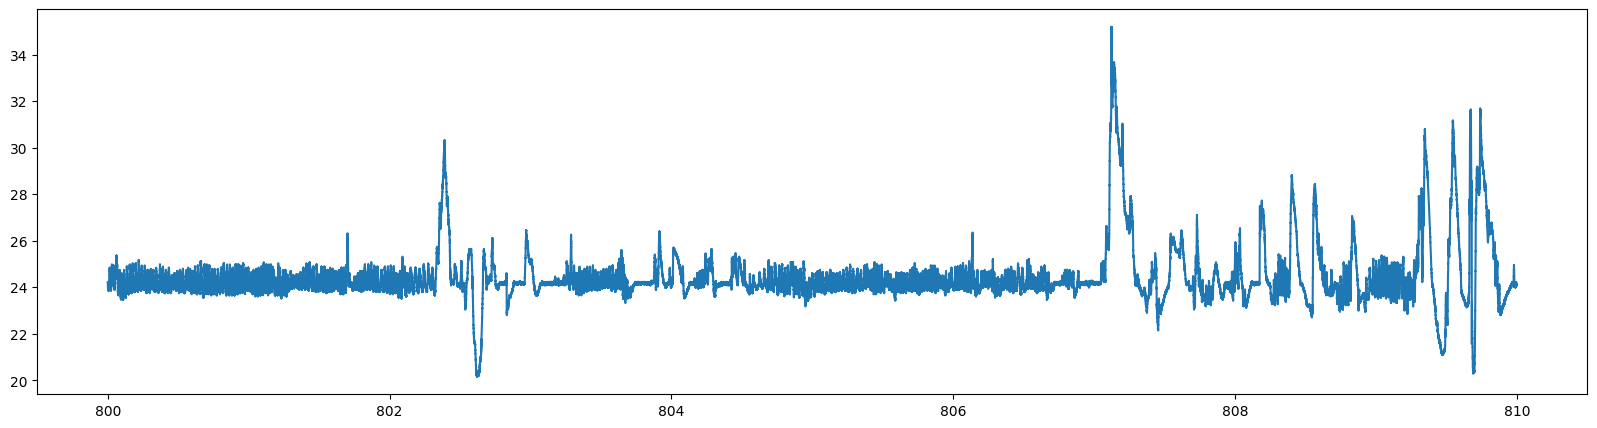

In [10]:
# Plot the RESP DATA
slice = 1
bin = int(signals_RESP[0].shape[0]/slice)
plt.figure(num=102, figsize=(20,5))
plt.plot(time_array_minutes_RESP[:bin], signals_RESP[0][:bin], label='RESP Data')

### Remove outlier with IQR

In [11]:
# ECG DATA - Description with IQR
print("ECG DATA")
print("-----------------------------------------------------------------------------------")
print(signals_ECG[1])
print(signals_ECG[0].shape)
print(f"Start time: {startTime_seconds_ECG} seconds, End time: {endTime_seconds_ECG} seconds")
print(f"Start time: {startTime_minutes_ECG} minutes, End time: {endTime_minutes_ECG} minutes")
print(f"Start time: {startTime_hours_ECG} hours, End time: {endTime_hours_ECG} hours")
print(dataframe_ECG.describe())
q75_ECG, q25_ECG = np.percentile(signals_ECG[0], [75, 27])
q90_ECG, q10_ECG = np.percentile(signals_ECG[0], [90, 10])
q95_ECG, q5_ECG = np.percentile(signals_ECG[0], [95, 5])
print(f"25th percentile: {q25_ECG}, 75th percentile: {q75_ECG}")
print(f"10th percentile: {q10_ECG}, 90th percentile: {q90_ECG}")
print(f"5th percentile: {q5_ECG}, 95th percentile: {q95_ECG}")

ECG DATA
-----------------------------------------------------------------------------------
{'fs': 250, 'sig_len': 150000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['ECG'], 'comments': []}
(150000, 1)
Start time: 48000.0 seconds, End time: 48600.0 seconds
Start time: 800.0 minutes, End time: 810.0 minutes
Start time: 13.333333333333334 hours, End time: 13.5 hours
                 ECG
count  150000.000000
mean       -0.028363
std         0.226349
min        -0.729399
25%        -0.129893
50%        -0.059951
75%         0.004996
max         1.947144
25th percentile: -0.11990112653353228, 75th percentile: 0.004995880272230512
10th percentile: -0.19359036054893233, 90th percentile: 0.054954682994535625
5th percentile: -0.2373043129309493, 95th percentile: 0.2997528163338307


In [12]:
# RESP DATA - Description with IQR 
print("RESP DATA")
print("-----------------------------------------------------------------------------------")
print(signals_RESP[1])
print(signals_RESP[0].shape)
print(f"Start time: {startTime_seconds_RESP} seconds, End time: {endTime_seconds_RESP} seconds")
print(f"Start time: {startTime_minutes_RESP} minutes, End time: {endTime_minutes_RESP} minutes")
print(f"Start time: {startTime_hours_RESP} hours, End time: {endTime_hours_RESP} hours")
print(dataframe_RESP.describe())
q75_RESP, q25_RESP = np.percentile(signals_RESP[0], [75, 27])
q90_RESP, q10_RESP = np.percentile(signals_RESP[0], [90, 10])
q95_RESP, q5_RESP = np.percentile(signals_RESP[0], [95, 5])
print(f"25th percentile: {q25_RESP}, 75th percentile: {q75_RESP}")
print(f"10th percentile: {q10_RESP}, 90th percentile: {q90_RESP}")
print(f"5th percentile: {q5_RESP}, 95th percentile: {q95_RESP}")

RESP DATA
-----------------------------------------------------------------------------------
{'fs': 500, 'sig_len': 300000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['NU'], 'sig_name': ['RESP'], 'comments': []}
(300000, 1)
Start time: 48000.0 seconds, End time: 48600.0 seconds
Start time: 800.0 minutes, End time: 810.0 minutes
Start time: 13.333333333333334 hours, End time: 13.5 hours
                RESP
count  300000.000000
mean       24.457941
std         1.281816
min        20.153339
25%        23.932463
50%        24.177143
75%        24.602351
max        35.191507
25th percentile: 23.939922521244142, 75th percentile: 24.602350889649504
10th percentile: 23.663164723182895, 90th percentile: 25.400547234462266
5th percentile: 23.416246040815583, 95th percentile: 26.91786626749887


In [13]:
# Interquartile 
iqr1_ECG = q75_ECG-q25_ECG
iqr2_ECG = q90_ECG-q10_ECG
iqr3_ECG = q95_ECG-q5_ECG
decimal_ECG = 3
print(f"ECG")
print(f"Percentiles: 25th={q25_ECG:.{decimal_ECG}f}, 75th={q75_ECG:.{decimal_ECG}f}, IQR={iqr1_ECG:.{decimal_ECG}f}")
print(f"Percentiles: 10th={q10_ECG:.{decimal_ECG}f}, 90th={q90_ECG:.{decimal_ECG}f}, IQR={iqr2_ECG:.{decimal_ECG}f}")
print(f"Percentiles: 5th={q5_ECG:.{decimal_ECG}f}, 95th={q95_ECG:.{decimal_ECG}f}, IQR={iqr3_ECG:.{decimal_ECG}f}")
print("--------------------------------")
iqr1_RESP = q75_RESP-q25_RESP
iqr2_RESP = q90_RESP-q10_RESP
iqr3_RESP = q95_RESP-q5_RESP
decimal_RESP = 3
print(f"RESP")
print(f"Percentiles: 25th={q25_RESP:.{decimal_RESP}f}, 75th={q75_RESP:.{decimal_RESP}f}, IQR={iqr1_RESP:.{decimal_RESP}f}")
print(f"Percentiles: 10th={q10_RESP:.{decimal_RESP}f}, 90th={q90_RESP:.{decimal_RESP}f}, IQR={iqr2_RESP:.{decimal_RESP}f}")
print(f"Percentiles: 5th={q5_RESP:.{decimal_RESP}f}, 95th={q95_RESP:.{decimal_RESP}f}, IQR={iqr3_RESP:.{decimal_RESP}f}")

ECG
Percentiles: 25th=-0.120, 75th=0.005, IQR=0.125
Percentiles: 10th=-0.194, 90th=0.055, IQR=0.249
Percentiles: 5th=-0.237, 95th=0.300, IQR=0.537
--------------------------------
RESP
Percentiles: 25th=23.940, 75th=24.602, IQR=0.662
Percentiles: 10th=23.663, 90th=25.401, IQR=1.737
Percentiles: 5th=23.416, 95th=26.918, IQR=3.502


In [53]:
# ECG DATA - Remove Outlier
# calculate the outlier cutoff
print("ECG DATA")
cut_off_ECG = iqr1_ECG * 1.5
lower_ECG, upper_ECG = q25_ECG - cut_off_ECG, q75_ECG + cut_off_ECG
# identify outliers
signals_ECG_outliers = [x for x in signals_ECG[0] if x < lower_ECG or x > upper_ECG]
print('Identified outliers: %d' % len(signals_ECG_outliers))
signals_ECG_1 = map(functools.partial(iqr_remove_outlier, lower=lower_ECG, upper=upper_ECG), signals_ECG[0])
print(signals_ECG_1)
signals_ECG_1 = np.fromiter(signals_ECG_1, dtype=np.float64)
print(f"ECG Data Shape: {signals_ECG_1.shape}")
print(signals_ECG_1)

ECG DATA
Identified outliers: 11940
ECG Data Shape: (150000,)
[-0.00999176 -0.00999176 -0.00749382 ... -0.14488053 -0.14987641
 -0.15986817]


In [15]:
# RESP DATA - Remove Outlier
# calculate the outlier cutoff
print("RESP DATA")
cut_off_RESP = iqr1_RESP * 1
lower_RESP, upper_RESP = q25_RESP - cut_off_RESP, q75_RESP + cut_off_RESP
# identify outliers
signals_RESP_outliers = [x for x in signals_RESP[0] if x < lower_RESP or x > upper_RESP]
print('Identified outliers: %d' % len(signals_ECG_outliers))
signals_RESP_1 =[]
signals_RESP_1 = map(functools.partial(iqr_remove_outlier, lower=lower_RESP, upper=upper_RESP), signals_RESP[0])
print(signals_RESP_1)
signals_RESP_1 = np.fromiter(signals_RESP_1, dtype=np.float64)
print(f"RESP Data Shape: {signals_RESP_1.shape}")
print(signals_RESP_1)

RESP DATA
Identified outliers: 11940
RESP Data Shape: (300000,)
[24.22264814 24.2241401  24.22115619 ... 24.07718245 24.12865493
 24.13163884]


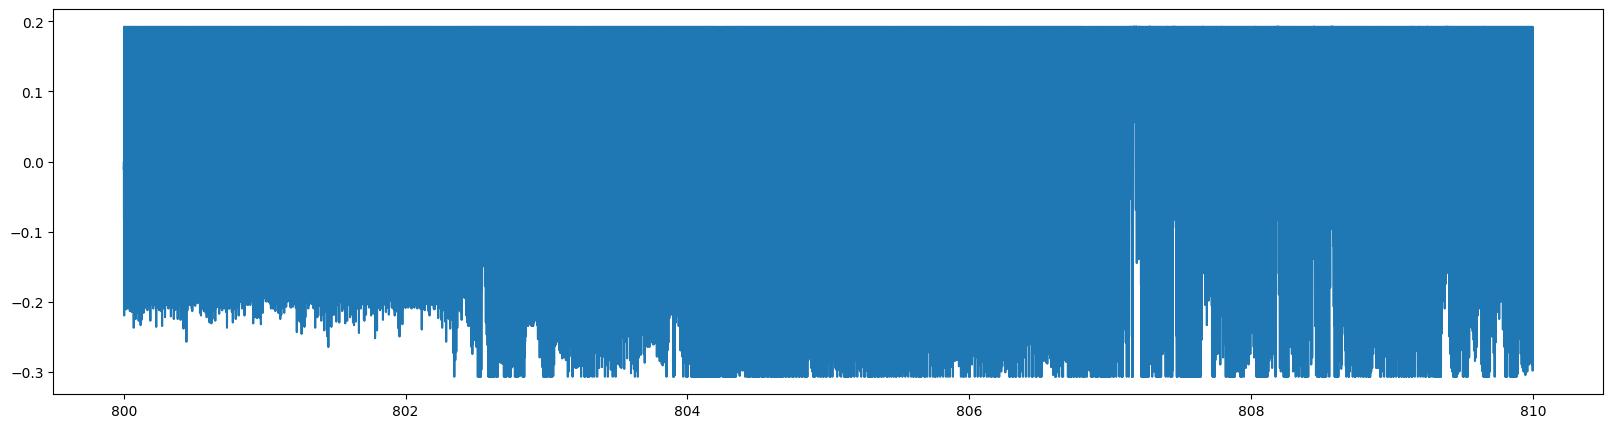

In [16]:
# Plot the ECG DATA
slice = 1
bin = int(signals_ECG_1.shape[0]/slice)
plt.figure(num=201, figsize=(20,5))
plt.plot(time_array_minutes_ECG[:bin], signals_ECG_1[:bin], label='ECG Data')

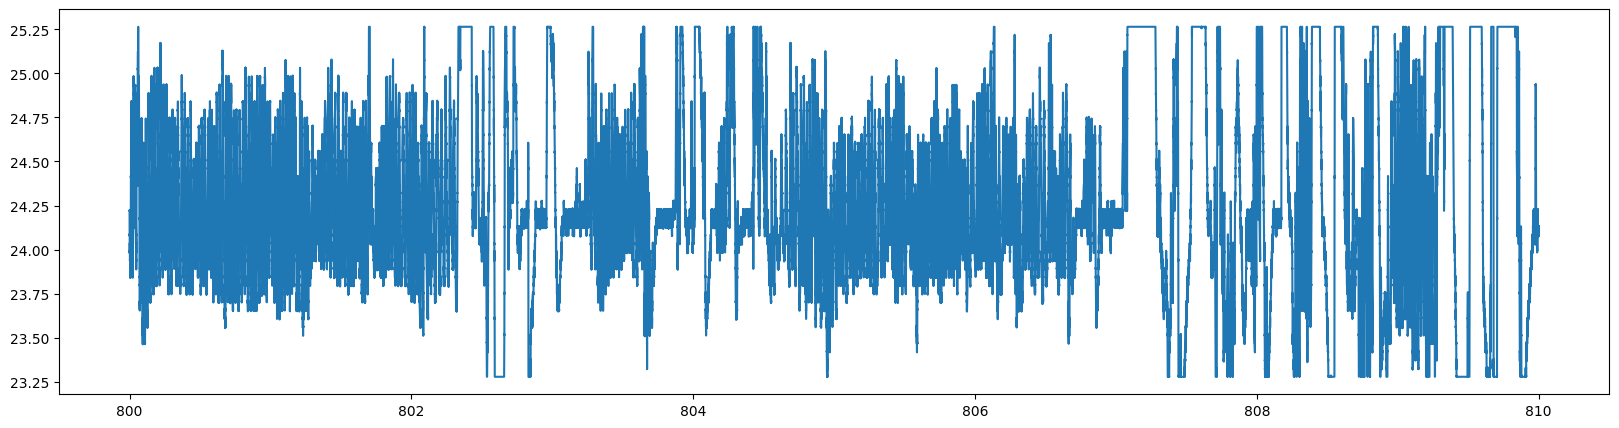

In [17]:
# Plot the RESP DATA
slice = 1
bin = int(signals_RESP_1.shape[0]/slice)
plt.figure(num=202, figsize=(20,5))
plt.plot(time_array_minutes_RESP[:bin], signals_RESP_1[:bin], label='RESP Data')

### Normalize data to (-1,1)

In [18]:
# Reshape the data
print(signals_ECG_1.shape)
signals_ECG_2 = signals_ECG_1.reshape(signals_ECG_1.shape[0],1)
print(signals_ECG_2.shape)
print(signals_RESP_1.shape)
signals_RESP_2 = signals_RESP_1.reshape(signals_RESP_1.shape[0],1)
print(signals_RESP_2.shape)

(150000,)
(150000, 1)
(300000,)
(300000, 1)


In [19]:
# Normalization
signals_ECG_3 = scaler.fit_transform(signals_ECG_2)
signals_RESP_3 = scaler.fit_transform(signals_RESP_2)

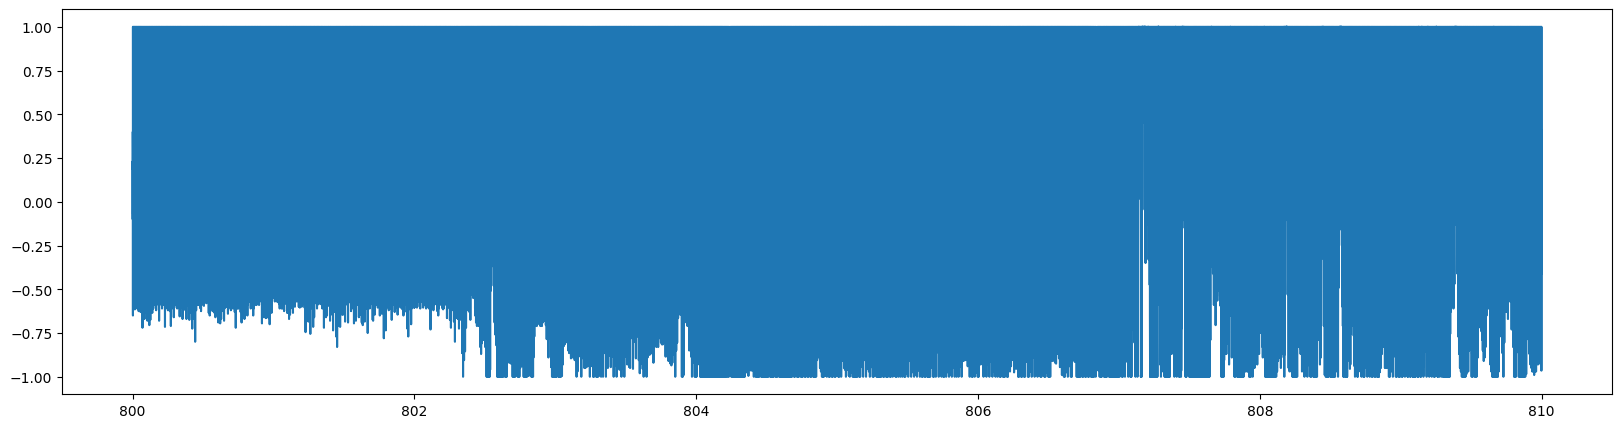

In [20]:
# Plot the ECG DATA
slice = 1
bin = int(signals_ECG_3.shape[0]/slice)
plt.figure(num=301, figsize=(20,5))
plt.plot(time_array_minutes_ECG[:bin], signals_ECG_3[:bin], label='ECG Data')

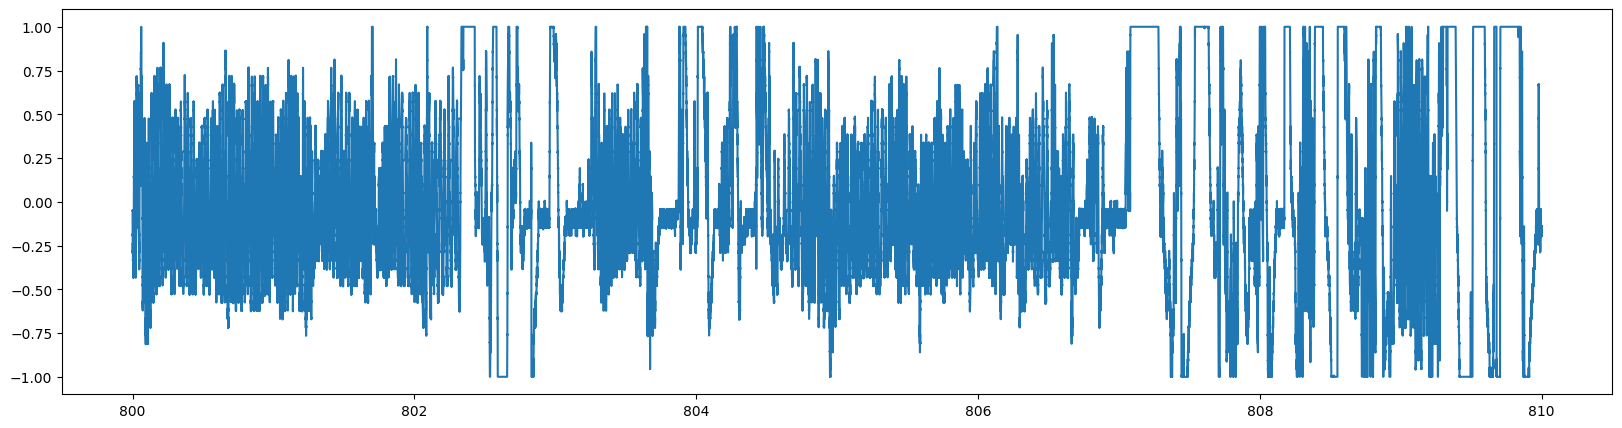

In [21]:
# Plot the RESP DATA
slice = 1
bin = int(signals_RESP_3.shape[0]/slice)
plt.figure(num=302, figsize=(20,5))
plt.plot(time_array_minutes_RESP[:bin], signals_RESP_3[:bin], label='RESP Data')

# Heart Rate and Respiration Rate

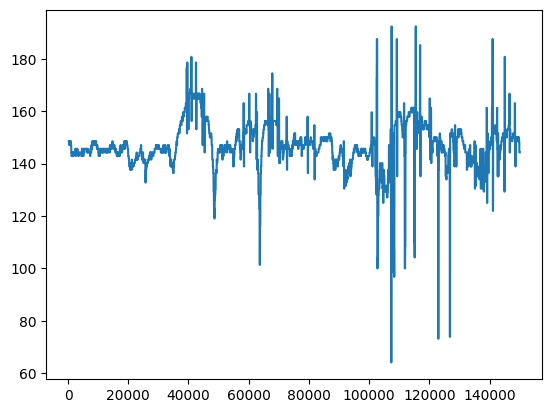

In [22]:
ECG_qrs_inds_1 = processing.qrs.gqrs_detect(sig=signals_ECG_3, fs=record_ECG.fs)
ECG_hrs_1 = processing.hr.compute_hr(sig_len=signals_ECG_3.shape[0], qrs_inds=ECG_qrs_inds_1, fs=record_ECG.fs)
plt.plot(ECG_hrs_1)

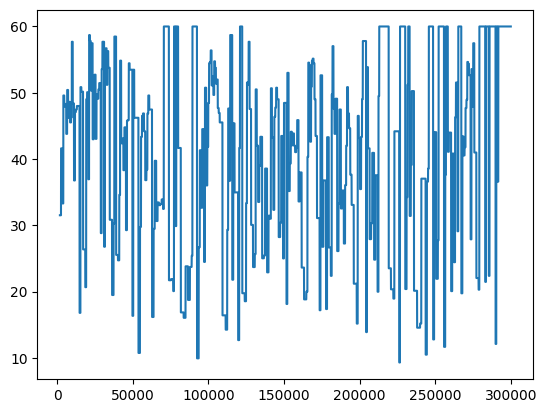

In [23]:
RESP_peak_inds_1 = processing.peaks.find_local_peaks(sig=signals_RESP_3, radius=record_RESP.fs)
RESP_rrs_1 = processing.hr.compute_hr(sig_len=signals_RESP_3.shape[0], qrs_inds=RESP_peak_inds_1, fs=record_RESP.fs)
plt.plot(RESP_rrs_1)

In [24]:
np.save(file='../data/infant_2_hrs_1.npy', arr=ECG_hrs_1)
np.save(file='../data/infant_2_rrs_1.npy', arr=RESP_rrs_1)

In [54]:
RESP_rrs_2 = pd.DataFrame(RESP_rrs_1).fillna(0).to_numpy().reshape(RESP_rrs_1.shape[0])
ECG_hrs_2 = pd.DataFrame(ECG_hrs_1).fillna(0).to_numpy().reshape(ECG_hrs_1.shape[0])
print(RESP_rrs_2.shape)
print(ECG_hrs_2.shape)

(300000,)
(150000,)


In [26]:
# Resample the data to same cardinality

if (RESP_rrs_2.shape[0] < ECG_hrs_2.shape[0]):
    ECG_hrs_3 = scipy.signal.resample(ECG_hrs_2, RESP_rrs_2.shape[0])
    RESP_rrs_3 = RESP_rrs_2
else:
    RESP_rrs_3 = scipy.signal.resample(RESP_rrs_2, ECG_hrs_2.shape[0])
    ECG_hrs_3 = ECG_hrs_2

### Correlation Test

(150000,)
[[216.56410799  -4.3599752 ]
 [ -4.3599752  130.15675968]]
Pearsons correlation: -0.026
Spearmans correlation: -0.022


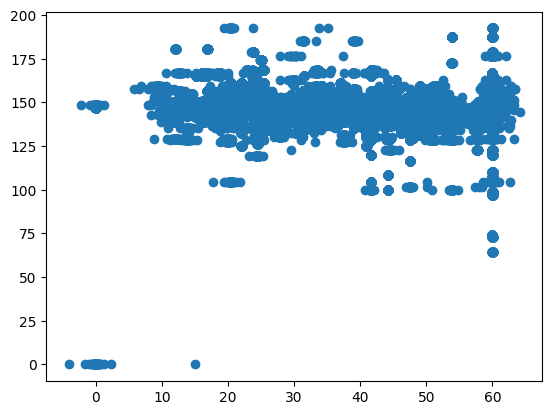

In [27]:
RESP_rrs_3 = pd.DataFrame(RESP_rrs_3).fillna(0).to_numpy().reshape(RESP_rrs_3.shape[0])
ECG_hrs_3 = pd.DataFrame(ECG_hrs_3).fillna(0).to_numpy().reshape(ECG_hrs_3.shape[0])
print(RESP_rrs_3.shape)
correlationTest(RESP_rrs_3[:],ECG_hrs_2[:])

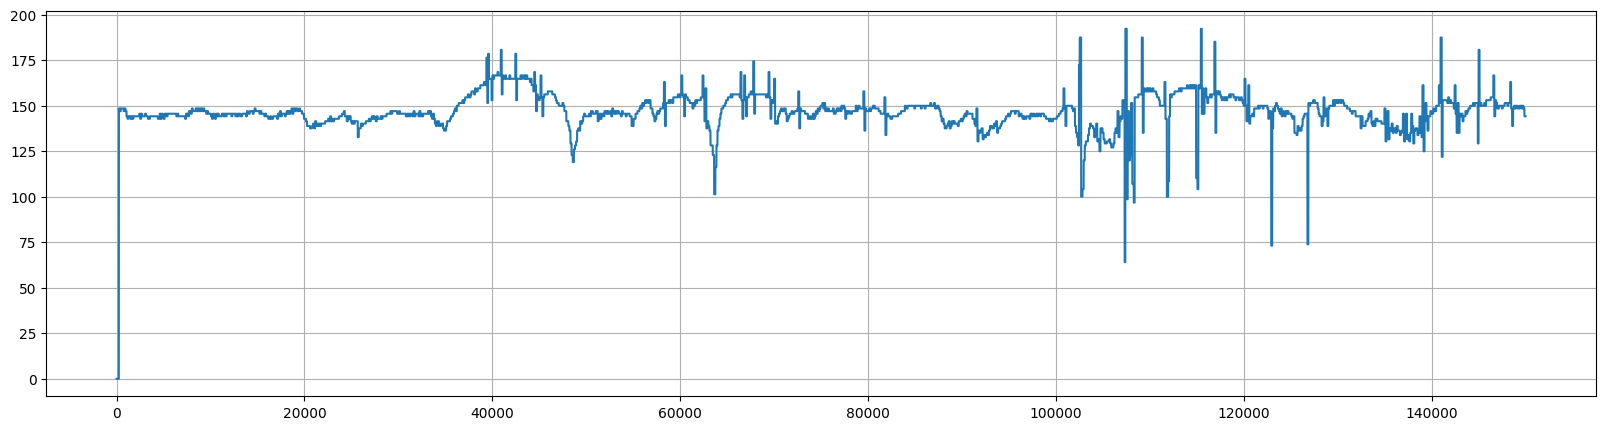

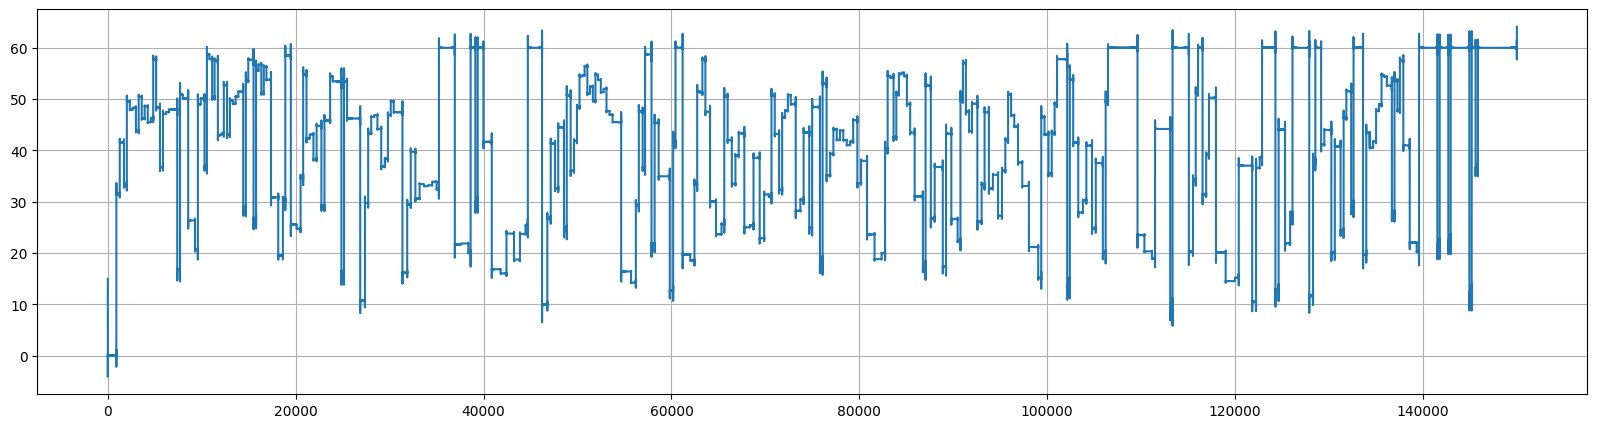

In [28]:
plt.figure(num=801, figsize=(20,5))
plt.plot(ECG_hrs_3)
plt.grid(True)

plt.figure(num=802, figsize=(20,5))
plt.plot(RESP_rrs_3)
plt.grid(True)

### Linear Regression

In [29]:
SEED = 42
X = RESP_rrs_3.reshape((-1,1))
print(X.shape)
y = ECG_hrs_3.reshape((-1,1))
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=SEED)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

(150000, 1)
(150000, 1)
X_train: (112500, 1), y_train: (112500, 1)
X_test: (37500, 1), y_test: (37500, 1)


In [30]:
lr_model = LinearRegression().fit(X_train, y_train)

In [31]:
r_sq = lr_model.score(X_train, y_train)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {lr_model.intercept_}")
print(f"coefficients: {lr_model.coef_}")

coefficient of determination: 0.0006932688996104108
intercept: [147.46959]
coefficients: [[-0.02040929]]


In [32]:
y_predict = lr_model.predict(X_test)

In [33]:
mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 6.44
Mean squared error: 129.60
Root mean squared error: 11.38


### Polynomial Regression

In [34]:
# polynomial of order 2 
transformer = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = transformer.fit_transform(X_train)
X_test_poly = transformer.fit_transform(X_test)
pr_model = LinearRegression().fit(X_train_poly, y_train)

In [35]:
r_sq = pr_model.score(X_train_poly, y_train)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {pr_model.intercept_}")
print(f"coefficients: {pr_model.coef_}")

coefficient of determination: 0.0010122509596016682
intercept: [148.61961]
coefficients: [[-0.09228192  0.00094701]]


In [36]:
y_test_predict = pr_model.predict(X_test_poly)
y_train_predict = pr_model.predict(X_train_poly)

In [55]:
print(y_test_predict.shape)

(37500, 1)


In [37]:
mae = mean_absolute_error(y_test, y_test_predict)
mse = mean_squared_error(y_test, y_test_predict)
rmse = np.sqrt(mse)
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')

Mean absolute error: 6.40
Mean squared error: 129.53
Root mean squared error: 11.38


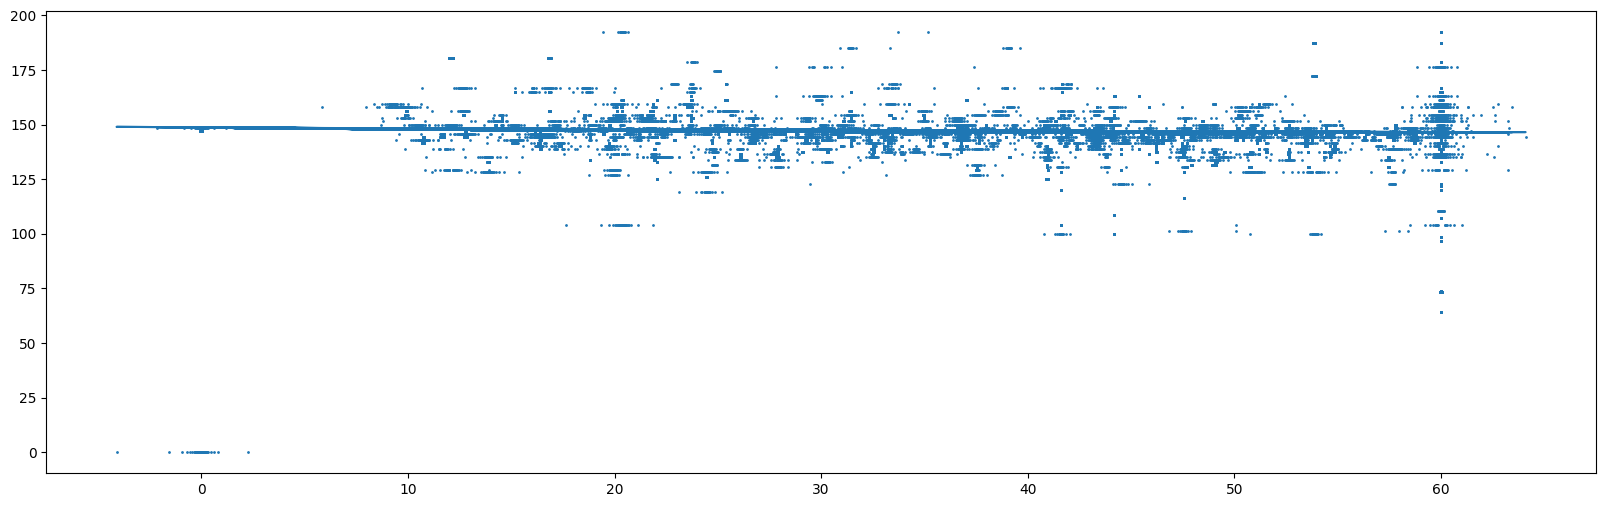

In [38]:
plt.figure(num=101, figsize=(20,6))
plt.scatter(X_train, y_train, s=1)
plt.plot(X_train, y_train_predict)

In [39]:
for i in range(2,20,1):
    print("----------------------------------------------------")
    print(f"order={i}")
    transformer = PolynomialFeatures(degree=i, include_bias=False)
    X_train_poly = transformer.fit_transform(X_train)
    X_test_poly = transformer.fit_transform(X_test)
    pr_model = LinearRegression().fit(X_train_poly, y_train)
    r_sq = pr_model.score(X_train_poly, y_train)
    print(f"coefficient of determination: {r_sq}")
    print(f"intercept: {pr_model.intercept_}")
    print(f"coefficients: {pr_model.coef_}")
    y_predict = pr_model.predict(X_test_poly)
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mse)
    print(f'Mean absolute error: {mae:.2f}')
    print(f'Mean squared error: {mse:.2f}')
    print(f'Root mean squared error: {rmse:.2f}')

----------------------------------------------------
order=2
coefficient of determination: 0.0010122509596016682
intercept: [148.61961]
coefficients: [[-0.09228192  0.00094701]]
Mean absolute error: 6.40
Mean squared error: 129.53
Root mean squared error: 11.38
----------------------------------------------------
order=3
coefficient of determination: 0.07446252320306412
intercept: [123.320435]
coefficients: [[ 2.7861664e+00 -8.9571193e-02  8.3863735e-04]]
Mean absolute error: 6.45
Mean squared error: 119.75
Root mean squared error: 10.94
----------------------------------------------------
order=4
coefficient of determination: 0.03226883252311652
intercept: [143.35808]
coefficients: [[ 1.8692224e-03  3.4969036e-02 -1.4005241e-03  1.4059246e-05]]
Mean absolute error: 6.33
Mean squared error: 125.26
Root mean squared error: 11.19
----------------------------------------------------
order=5
coefficient of determination: 0.024272199770617564
intercept: [148.00478]
coefficients: [[ 4.275368

----------------------------------------------------
order=10
coefficient of determination: 0.021987090719352786
intercept: [148.03151]
coefficients: [[-4.3499510e-23  1.2810614e-14  1.8835472e-17 -4.3369898e-18
  -1.5025410e-16 -4.7595645e-15 -1.2533671e-13 -2.2021196e-12
   6.8183896e-14 -5.2287683e-16]]
Mean absolute error: 6.24
Mean squared error: 126.60
Root mean squared error: 11.25


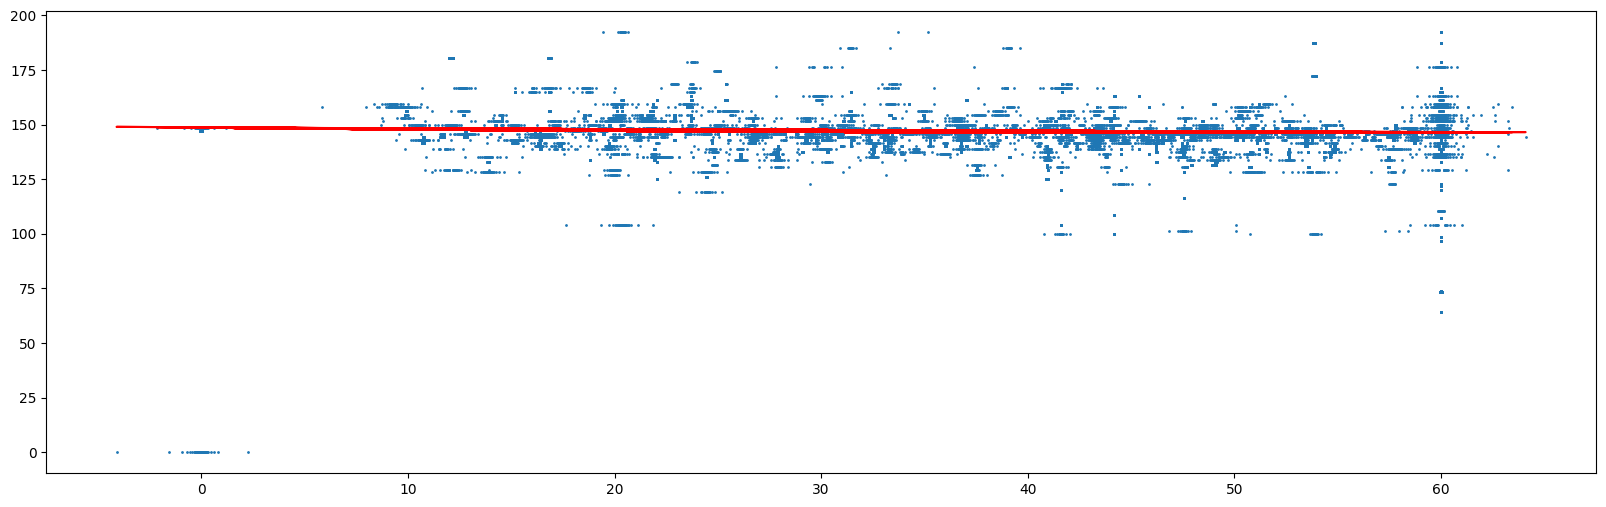

In [52]:
print("----------------------------------------------------")
order = 10
print(f"order={order}")
transformer = PolynomialFeatures(degree=order, include_bias=False)
X_train_poly = transformer.fit_transform(X_train)
X_test_poly = transformer.fit_transform(X_test)
pr_model = LinearRegression().fit(X_train_poly, y_train)
r_sq = pr_model.score(X_train_poly, y_train)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {pr_model.intercept_}")
print(f"coefficients: {pr_model.coef_}")
y_predict = pr_model.predict(X_test_poly)
mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
rmse = np.sqrt(mse)
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
plt.figure(num=101, figsize=(20,6))
plt.scatter(X_train, y_train, s=1)
plt.plot(X_train, y_train_predict, color='red')

### Support Vector Regression (SVR)

In [41]:
X_train = X_train.reshape((-1,1))
print(X_train.shape)
y_train = y_train.reshape((-1,1))
print(y_train.shape)
X_test = X_test.reshape((-1,1))
print(X_test.shape)
y_test = y_test.reshape((-1,1))
print(y_test.shape)

(112500, 1)
(112500, 1)
(37500, 1)
(37500, 1)


In [42]:
StdS_X = StandardScaler()
StdS_y = StandardScaler()
X_train_l = StdS_X.fit_transform(X_train)
y_train_p = StdS_y.fit_transform(y_train)
X_test_l = StdS_X.fit_transform(X_test)
y_test_p = StdS_y.fit_transform(y_test)

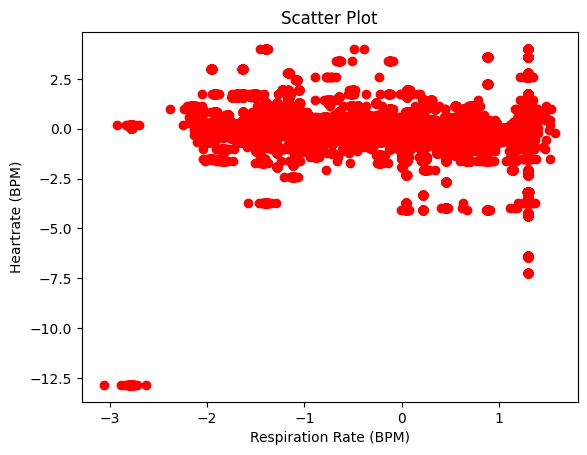

In [43]:
plt.scatter(X_train_l, y_train_p, color = 'red') # plotting the training set
plt.title('Scatter Plot') # adding a tittle to our plot
plt.xlabel('Respiration Rate (BPM)') # adds a label to the x-axis
plt.ylabel('Heartrate (BPM)') # adds a label to the y-axis
plt.show() # prints

In [44]:
# create the model object
svr_regressor = SVR(kernel = 'rbf')
# fit the model on the data
svr_regressor.fit(X_train_l, y_train_p)

e:\UniMalaya\MCS-AC\WOA7015AdvancedMachineLearning\FinalExamAssessment\mcs_aml_venv_1\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [45]:
y_test_p_predict = svr_regressor.predict(X_test_l)

In [46]:
print(y_test_p_predict.shape)
y_test_predict = StdS_y.inverse_transform(y_test_p_predict.reshape(-1,1))

(37500,)


In [47]:
r_sq = svr_regressor.score(X_train_l, y_train_p)
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {svr_regressor.intercept_}")
# print(f"coefficients: {svr_regressor.coef_}")

coefficient of determination: 0.03611092808514249
intercept: [0.77642515]


Mean absolute error: 6.03
Mean squared error: 124.57
Root mean squared error: 11.16


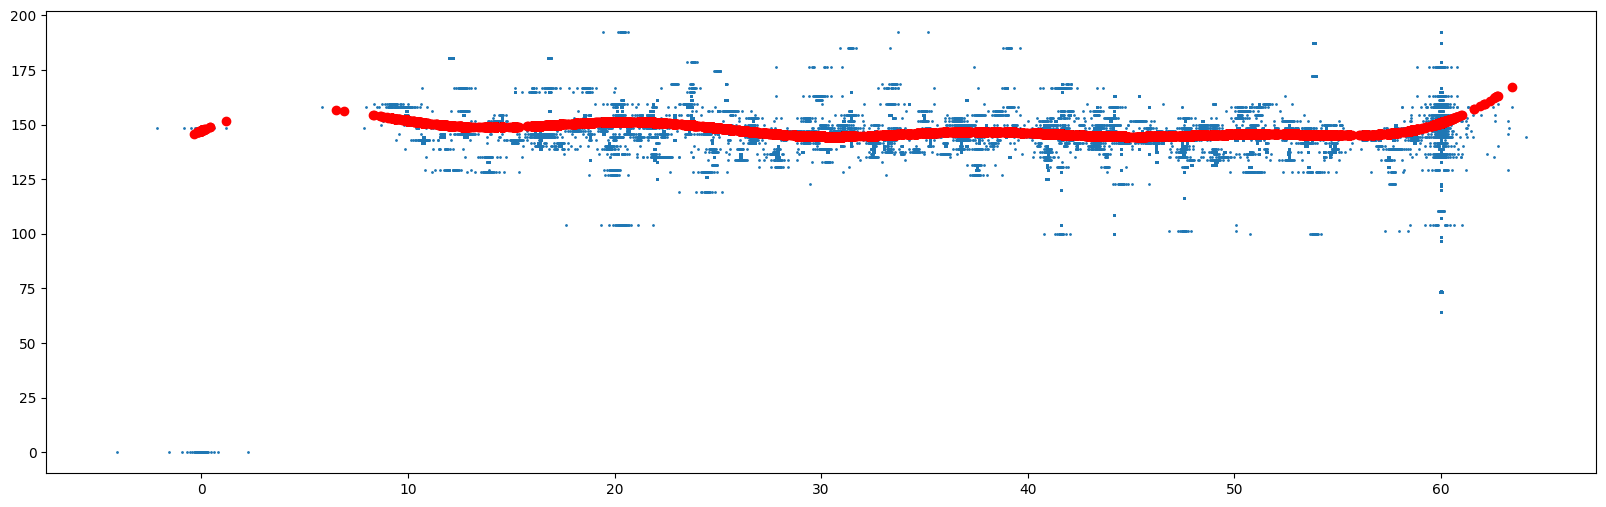

In [51]:
mae = mean_absolute_error(y_test, y_test_predict)
mse = mean_squared_error(y_test, y_test_predict)
rmse = np.sqrt(mse)
print(f'Mean absolute error: {mae:.2f}')
print(f'Mean squared error: {mse:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
plt.figure(num=101, figsize=(20,6))
plt.scatter(X_train, y_train, s=1)
plt.scatter(X_test, y_test_predict, color='red')